# Event Study Replication of Mello (2024)

This notebook replicates the event study analysis from:

> Mello, M. (2024). "A Kick for the GDP: The Effect of Winning the FIFA World Cup." 
> *Oxford Bulletin of Economics and Statistics*, 86(6), 1313-1341.

## Methodology

The event study specification (Equation 1 in Mello):

$$\Delta_4 GDP_{c,t} = \sum_{l \neq 0} \beta_l WIN^l_{c,t} + \theta_1 HOST_{c,t} + \zeta_1 GDP_{c,t-4} + \alpha_c + \mu_t + \epsilon_{c,t}$$

Where:
- $\Delta_4 GDP_{c,t}$ is year-over-year GDP growth
- $WIN^l_{c,t}$ are relative-time indicators (l = -16 to +16, excluding l=0)
- $HOST_{c,t}$ controls for hosting effects
- $GDP_{c,t-4}$ is lagged log GDP (convergence control)
- $\alpha_c$ are country fixed effects
- $\mu_t$ are quarter fixed effects

**Key finding**: Winning increases YoY GDP growth by ~0.48pp in the two subsequent quarters.

In [1]:
%pip install pandas numpy pyfixest matplotlib seaborn --quiet

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns
import os

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
np.set_printoptions(precision=4)

# Create results directory if needed
os.makedirs('../../mello_paper_replication/results', exist_ok=True)

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 1. Load and Prepare Data

In [5]:
# Load the paper replication sample
df = pd.read_csv('../../data/mello_paper_replication/paper_replication_sample.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nCountries: {df['country'].nunique()}")
print(f"Date range: {df['quarter'].min()} to {df['quarter'].max()}")

Dataset shape: (8633, 35)

Columns: ['country', 'quarter', 'gdp', 'private_consumption', 'government_consumption', 'capital_formation', 'exports', 'imports', 'population', 'host', 'rank1', 'rank2', 'rank3', 'rank4', 'host_won', 'host_top4', 'year', 'qtr', 'q_index', 'gdp_yoy_log_4q', 'private_consumption_yoy_log_4q', 'government_consumption_yoy_log_4q', 'capital_formation_yoy_log_4q', 'exports_yoy_log_4q', 'imports_yoy_log_4q', 'population_yoy_log_4q', 'gdp_yoy_pct', 'private_consumption_yoy_pct', 'government_consumption_yoy_pct', 'capital_formation_yoy_pct', 'exports_yoy_pct', 'imports_yoy_pct', 'population_yoy_pct', 'tq', 'winner']

Countries: 48
Date range: 1962-Q1 to 2021-Q4


In [6]:
# Check key columns
print("Sample of data:")
df.head(10)

Sample of data:


,country,quarter,gdp,private_consumption,government_consumption,capital_formation,exports,imports,population,host,rank1,rank2,rank3,rank4,host_won,host_top4,year,qtr,q_index,gdp_yoy_log_4q,private_consumption_yoy_log_4q,government_consumption_yoy_log_4q,capital_formation_yoy_log_4q,exports_yoy_log_4q,imports_yoy_log_4q,population_yoy_log_4q,gdp_yoy_pct,private_consumption_yoy_pct,government_consumption_yoy_pct,capital_formation_yoy_pct,exports_yoy_pct,imports_yoy_pct,population_yoy_pct,tq,winner
0,ARG,1994-Q1,691019.6000,NaN,NaN,NaN,NaN,NaN,34613491.0000,0,0,0,0,0,0,0,1994,1,7977,7.0169,NaN,NaN,NaN,NaN,NaN,1.3401,7.2689,NaN,NaN,NaN,NaN,NaN,1.3492,7977,0
1,ARG,1994-Q2,705311.7000,NaN,NaN,NaN,NaN,NaN,34613491.0000,0,0,0,0,0,0,0,1994,2,7978,6.2510,NaN,NaN,NaN,NaN,NaN,1.3401,6.4505,NaN,NaN,NaN,NaN,NaN,1.3492,7978,0
2,ARG,1994-Q3,707091.8000,NaN,NaN,NaN,NaN,NaN,34613491.0000,0,0,0,0,0,0,0,1994,3,7979,4.5128,NaN,NaN,NaN,NaN,NaN,1.3401,4.6162,NaN,NaN,NaN,NaN,NaN,1.3492,7979,0
3,ARG,1994-Q4,715866.3000,NaN,NaN,NaN,NaN,NaN,34613491.0000,0,0,0,0,0,0,0,1994,4,7980,4.9439,NaN,NaN,NaN,NaN,NaN,1.3401,5.0681,NaN,NaN,NaN,NaN,NaN,1.3492,7980,0
4,ARG,1995-Q1,704819.7000,NaN,NaN,NaN,NaN,NaN,35070020.0000,0,0,0,0,0,0,0,1995,1,7981,1.9774,NaN,NaN,NaN,NaN,NaN,1.3103,1.9971,NaN,NaN,NaN,NaN,NaN,1.3189,7981,0
5,ARG,1995-Q2,678104.8000,NaN,NaN,NaN,NaN,NaN,35070020.0000,0,0,0,0,0,0,0,1995,2,7982,-3.9338,NaN,NaN,NaN,NaN,NaN,1.3103,-3.8574,NaN,NaN,NaN,NaN,NaN,1.3189,7982,0
6,ARG,1995-Q3,675485.3000,NaN,NaN,NaN,NaN,NaN,35070020.0000,0,0,0,0,0,0,0,1995,3,7983,-4.5729,NaN,NaN,NaN,NaN,NaN,1.3103,-4.4699,NaN,NaN,NaN,NaN,NaN,1.3189,7983,0
7,ARG,1995-Q4,680664.9000,NaN,NaN,NaN,NaN,NaN,35070020.0000,0,0,0,0,0,0,0,1995,4,7984,-5.0423,NaN,NaN,NaN,NaN,NaN,1.3103,-4.9173,NaN,NaN,NaN,NaN,NaN,1.3189,7984,0
8,ARG,1996-Q1,699380.8000,NaN,NaN,NaN,NaN,NaN,35513793.0000,0,0,0,0,0,0,0,1996,1,7985,-0.7747,NaN,NaN,NaN,NaN,NaN,1.2575,-0.7717,NaN,NaN,NaN,NaN,NaN,1.2654,7985,0
9,ARG,1996-Q2,714968.4000,NaN,NaN,NaN,NaN,NaN,35513793.0000,0,0,0,0,0,0,0,1996,2,7986,5.2936,NaN,NaN,NaN,NaN,NaN,1.2575,5.4363,NaN,NaN,NaN,NaN,NaN,1.2654,7986,0


In [7]:
# Define country groups per Mello's paper (Table 2)
CONTROLS = [
    "ARG", "AUS", "AUT", "BEL", "BGR", "CAN", "CHL", "COL", "CRI", "HRV",
    "CZE", "DNK", "EST", "FIN", "GRC", "HUN", "IND", "IDN", "ISL", "IRL",
    "ISR", "LVA", "LTU", "LUX", "NLD", "NZL", "NOR", "POL", "PRT", "ROU",
    "SAU", "SVK", "SVN", "SWE", "CHE", "TUR"
]

HOSTS = ["BRA", "GBR", "FRA", "DEU", "ITA", "JPN", "MEX", "ZAF", "KOR", "ESP", "RUS", "USA"]

# Winners with their winning years
WINNERS = {
    'GBR': [1966],           # England
    'DEU': [1974, 1990, 2014],  # Germany (West Germany for 1974, 1990)
    'ITA': [1982, 2006],
    'FRA': [1998, 2018],
    'BRA': [2002],           # Only 2002 is in-sample (GDP starts 1998-Q2)
    'ESP': [2010]
}

# Host years
HOST_YEARS = {
    'GBR': [1966], 'MEX': [1970, 1986], 'DEU': [1974, 2006], 'ESP': [1982],
    'ITA': [1990], 'USA': [1994], 'FRA': [1998], 'JPN': [2002], 'KOR': [2002],
    'ZAF': [2010], 'BRA': [2014], 'RUS': [2018]
}

ALL_COUNTRIES = sorted(set(CONTROLS + HOSTS))
print(f"Total countries in sample: {len(ALL_COUNTRIES)}")
print(f"Winner countries: {list(WINNERS.keys())}")
print(f"Host countries: {list(HOST_YEARS.keys())}")

Total countries in sample: 48
Winner countries: ['GBR', 'DEU', 'ITA', 'FRA', 'BRA', 'ESP']
Host countries: ['GBR', 'MEX', 'DEU', 'ESP', 'ITA', 'USA', 'FRA', 'JPN', 'KOR', 'ZAF', 'BRA', 'RUS']


## 2. Filter Sample per Mello's Specification

In [8]:
# Filter to paper countries
df = df[df['country'].isin(ALL_COUNTRIES)].copy()

# Apply date filters
df = df[(df['quarter'] >= '1961-Q1') & (df['quarter'] <= '2021-Q4')]

# Brazil's GDP starts only from 1998-Q2 (per Mello's Table 1)
df = df[~((df['country'] == 'BRA') & (df['quarter'] < '1998-Q2'))]

print(f"Filtered sample: {len(df):,} rows, {df['country'].nunique()} countries")

Filtered sample: 8,633 rows, 48 countries


In [9]:
# Create time index (tq = year*4 + quarter for sorting/calculations)
df['year'] = df['quarter'].str[:4].astype(int)
df['qtr'] = df['quarter'].str[-1].astype(int)
df['tq'] = df['year'] * 4 + df['qtr']

df = df.sort_values(['country', 'tq']).reset_index(drop=True)
print(f"Time index range: {df['tq'].min()} to {df['tq'].max()}")

Time index range: 7849 to 8088


## 3. Create Regression Variables

In [10]:
# Outcome variable: YoY GDP growth (percentage points)
# Using the pre-calculated column from the dataset
df['dy_gdp'] = df['gdp_yoy_pct']  # This is year-over-year GDP growth in percentage points

# Lagged log GDP (4 quarters ago for convergence control)
df['ln_gdp'] = np.log(df['gdp'])
df['ln_gdp_l4'] = df.groupby('country')['ln_gdp'].shift(4)

# Host indicator (1 in the year of hosting)
df['is_host'] = df['host'].fillna(0).astype(int)

print(f"Outcome (dy_gdp) - mean: {df['dy_gdp'].mean():.3f}, std: {df['dy_gdp'].std():.3f}")
print(f"Missing dy_gdp: {df['dy_gdp'].isna().sum():,}")

Outcome (dy_gdp) - mean: 3.236, std: 3.881
Missing dy_gdp: 0


## 4. Construct WIN Relative Time Indicators

In [11]:
# Create win events dataframe
win_events = []
for country, years in WINNERS.items():
    for year in years:
        # World Cup finals are in Q2 (June/July)
        tq_event = year * 4 + 2  # Q2 of winning year
        win_events.append({'country': country, 'year': year, 'tq_event': tq_event})

win_events_df = pd.DataFrame(win_events)
print("Win events:")
print(win_events_df)

Win events:
  country  year  tq_event
0     GBR  1966      7866
1     DEU  1974      7898
2     DEU  1990      7962
3     DEU  2014      8058
4     ITA  1982      7930
5     ITA  2006      8026
6     FRA  1998      7994
7     FRA  2018      8074
8     BRA  2002      8010
9     ESP  2010      8042


In [12]:
def compute_relative_time(row, events_df):
    """
    Compute relative time to nearest win event for a country.
    For countries with multiple wins, l restarts halfway between consecutive wins.
    """
    country = row['country']
    tq = row['tq']
    
    # Get events for this country
    ctry_events = events_df[events_df['country'] == country]['tq_event'].sort_values().values
    
    if len(ctry_events) == 0:
        return np.nan  # Not a winner country
    
    # Find the relevant event (nearest, respecting midpoint restart rule)
    rel_times = []
    for i, evt in enumerate(ctry_events):
        rel_time = tq - evt
        
        # For multiple wins: check if we're past the midpoint to next win
        if i < len(ctry_events) - 1:
            next_evt = ctry_events[i + 1]
            midpoint = (evt + next_evt) // 2
            if tq >= midpoint:
                continue  # This quarter belongs to the next event
        
        # Check if we're before the midpoint from previous win
        if i > 0:
            prev_evt = ctry_events[i - 1]
            midpoint = (prev_evt + evt) // 2
            if tq < midpoint:
                continue  # This quarter belongs to the previous event
        
        return rel_time
    
    # If still here, assign to the last event
    return tq - ctry_events[-1]

# Apply to dataframe
df['rel_time_win'] = df.apply(lambda r: compute_relative_time(r, win_events_df), axis=1)

# Create is_winner indicator
df['is_winner'] = df['country'].isin(WINNERS.keys()).astype(int)

# Bin relative time to [-16, +16] range (endpoints capture all distant quarters)
df['rel_time_bin'] = df['rel_time_win'].clip(-16, 16)

print("\nRelative time distribution for winners:")
print(df[df['is_winner'] == 1]['rel_time_bin'].value_counts().sort_index())


Relative time distribution for winners:
rel_time_bin
-16.0000    519
-15.0000     10
-14.0000     10
-13.0000     10
-12.0000     10
-11.0000     10
-10.0000     10
-9.0000      10
-8.0000      10
-7.0000      10
-6.0000      10
-5.0000      10
-4.0000      10
-3.0000      10
-2.0000      10
-1.0000      10
0.0000       10
1.0000       10
2.0000       10
3.0000       10
4.0000       10
5.0000       10
6.0000       10
7.0000       10
8.0000       10
9.0000       10
10.0000      10
11.0000      10
12.0000      10
13.0000      10
14.0000      10
15.0000       9
16.0000     467
Name: count, dtype: int64


In [13]:
# Create WIN_l indicator variables for l = -16 to +16 (excluding l=0)
# These take value 1 for winners at relative time l, 0 otherwise

for l in range(-16, 17):
    if l == 0:
        continue  # Skip reference period
    
    col_name = f'WIN_m{abs(l)}' if l < 0 else f'WIN_p{l}'
    df[col_name] = ((df['rel_time_bin'] == l) & (df['is_winner'] == 1)).astype(int)

# Verify
win_cols = [c for c in df.columns if c.startswith('WIN_')]
print(f"Created {len(win_cols)} WIN indicator variables")
print(f"\nWIN indicators sum (should be > 0 for each):")
print(df[win_cols].sum().to_dict())

Created 32 WIN indicator variables

WIN indicators sum (should be > 0 for each):
{'WIN_m16': 519, 'WIN_m15': 10, 'WIN_m14': 10, 'WIN_m13': 10, 'WIN_m12': 10, 'WIN_m11': 10, 'WIN_m10': 10, 'WIN_m9': 10, 'WIN_m8': 10, 'WIN_m7': 10, 'WIN_m6': 10, 'WIN_m5': 10, 'WIN_m4': 10, 'WIN_m3': 10, 'WIN_m2': 10, 'WIN_m1': 10, 'WIN_p1': 10, 'WIN_p2': 10, 'WIN_p3': 10, 'WIN_p4': 10, 'WIN_p5': 10, 'WIN_p6': 10, 'WIN_p7': 10, 'WIN_p8': 10, 'WIN_p9': 10, 'WIN_p10': 10, 'WIN_p11': 10, 'WIN_p12': 10, 'WIN_p13': 10, 'WIN_p14': 10, 'WIN_p15': 9, 'WIN_p16': 467}


## 5. Prepare Final Regression Sample

In [14]:
# Keep only complete cases for regression
reg_vars = ['dy_gdp', 'ln_gdp_l4', 'is_host', 'country', 'tq'] + win_cols
df_reg = df[reg_vars + ['quarter', 'year', 'qtr', 'is_winner', 'rel_time_bin']].dropna(subset=['dy_gdp', 'ln_gdp_l4']).copy()

print(f"\nRegression sample: {len(df_reg):,} observations")
print(f"Countries: {df_reg['country'].nunique()}")
print(f"Winners obs: {df_reg['is_winner'].sum():,}")
print(f"Controls obs: {(1 - df_reg['is_winner']).sum():,}")


Regression sample: 8,441 observations
Countries: 48
Winners obs: 1,271
Controls obs: 7,170


## 6. Estimate Event Study (Main Specification)

In [15]:
# Build regression formula
# Outcome: dy_gdp (YoY GDP growth in pp)
# Controls: ln_gdp_l4 (lagged log GDP), is_host (host indicator)
# Fixed effects: country + tq (time quarter)
# WIN indicators: WIN_m16, WIN_m15, ..., WIN_m1, WIN_p1, ..., WIN_p16

win_vars = ' + '.join(win_cols)
formula = f'dy_gdp ~ ln_gdp_l4 + is_host + {win_vars} | country + tq'

print("Estimating event study model...")
print(f"\nFormula: {formula[:100]}...")

Estimating event study model...

Formula: dy_gdp ~ ln_gdp_l4 + is_host + WIN_m16 + WIN_m15 + WIN_m14 + WIN_m13 + WIN_m12 + WIN_m11 + WIN_m10 +...


In [23]:
# Estimate with pyfixest, clustered SEs at country level
model = pf.feols(formula, data=df_reg, vcov={'CRV1': 'country'})

print(model.summary())

###

Estimation:  OLS
Dep. var.: dy_gdp, Fixed effects: country+tq
Inference:  CRV1
Observations:  8441

| Coefficient   |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:--------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| ln_gdp_l4     |     -1.532 |        0.726 |    -2.109 |      0.040 | -2.993 |  -0.071 |
| is_host       |     -0.574 |        0.504 |    -1.138 |      0.261 | -1.589 |   0.441 |
| WIN_m16       |      0.752 |        0.687 |     1.095 |      0.279 | -0.630 |   2.134 |
| WIN_m15       |      1.070 |        0.422 |     2.536 |      0.015 |  0.221 |   1.918 |
| WIN_m14       |      1.125 |        0.529 |     2.125 |      0.039 |  0.060 |   2.189 |
| WIN_m13       |      0.534 |        0.459 |     1.165 |      0.250 | -0.388 |   1.457 |
| WIN_m12       |      0.040 |        0.495 |     0.081 |      0.936 | -0.955 |   1.035 |
| WIN_m11       |     -0.157 |        0.607 |    -0.259 |      0.796 | -1.378 |   1.0

## 7. Extract and Display Results

In [24]:
# Extract coefficients for WIN indicators
coef_df = model.tidy().copy()
print("Column names from tidy():", coef_df.columns.tolist())

# Reset index to make coefficient names a column
coef_df = coef_df.reset_index()

# Standardize column names (pyfixest uses lowercase)
coef_df.columns = [str(c).lower().replace(' ', '_').replace('.', '_') for c in coef_df.columns]
# Rename to standard names
col_map = {
    'coefficient': 'term', 'term': 'term',
    'estimate': 'estimate',
    'std__error': 'std_error', 'std_error': 'std_error',
    't_value': 't_value', 'statistic': 't_value',
    'pr(>|t|)': 'p_value', 'p_value': 'p_value',
    '2_5%': 'ci_low', 'conf_low': 'ci_low',
    '97_5%': 'ci_high', 'conf_high': 'ci_high'
}
coef_df = coef_df.rename(columns={k: v for k, v in col_map.items() if k in coef_df.columns})

# Filter to WIN coefficients
term_col = next((c for c in ['coefficient', 'term', 'index'] if c in coef_df.columns), coef_df.columns[0])
coef_df = coef_df[coef_df[term_col].astype(str).str.startswith('WIN_')].copy()

# Parse relative time from coefficient name
def parse_rel_time(name):
    if name.startswith('WIN_m'):
        return -int(name.replace('WIN_m', ''))
    elif name.startswith('WIN_p'):
        return int(name.replace('WIN_p', ''))
    return 0

coef_df['rel_time'] = coef_df[term_col].apply(parse_rel_time)
coef_df = coef_df.sort_values('rel_time')

# Add reference period (l=0) with coefficient 0
ref_row = pd.DataFrame([{
    term_col: 'WIN_0',
    'estimate': 0.0,
    'std_error': 0.0,
    't_value': np.nan,
    'p_value': np.nan,
    'ci_low': 0.0,
    'ci_high': 0.0,
    'rel_time': 0
}])
coef_df = pd.concat([coef_df, ref_row], ignore_index=True).sort_values('rel_time')

print("\nEvent Study Coefficients (Effect of Winning on YoY GDP Growth):")
print(coef_df[['rel_time', 'estimate', 'std_error', 't_value', 'p_value', 'ci_low', 'ci_high']].to_string(index=False))

Column names from tidy(): ['Estimate', 'Std. Error', 't value', 'Pr(>|t|)', '2.5%', '97.5%']

Event Study Coefficients (Effect of Winning on YoY GDP Growth):
 rel_time  estimate  std_error  t_value  p_value  ci_low  ci_high
      -16    0.7520     0.6868   1.0949   0.2791 -0.6297   2.1337
      -15    1.0698     0.4218   2.5361   0.0146  0.2212   1.9185
      -14    1.1248     0.5292   2.1253   0.0389  0.0601   2.1894
      -13    0.5341     0.4585   1.1647   0.2500 -0.3884   1.4565
      -12    0.0399     0.4947   0.0807   0.9360 -0.9553   1.0351
      -11   -0.1574     0.6066  -0.2595   0.7964 -1.3778   1.0630
      -10    0.2432     0.7578   0.3210   0.7497 -1.2813   1.7678
       -9    0.0263     0.6106   0.0430   0.9659 -1.2022   1.2547
       -8    0.1963     0.7006   0.2803   0.7805 -1.2130   1.6057
       -7    0.3342     0.5904   0.5660   0.5741 -0.8536   1.5220
       -6    0.2330     0.6083   0.3831   0.7034 -0.9907   1.4568
       -5    0.5929     0.6030   0.9832   0.3305 -

In [26]:
# Highlight key coefficients (post-victory: l=1 and l=2)
print("\n" + "="*60)
print("KEY RESULTS: Effect of Winning the World Cup")
print("="*60)

for l in [1, 2]:
    row = coef_df[coef_df['rel_time'] == l].iloc[0]
    p_val = row['p_value'] if pd.notna(row['p_value']) else 1.0
    sig = '***' if p_val < 0.01 else '**' if p_val < 0.05 else '*' if p_val < 0.1 else ''
    print(f"\nl = +{l} (Q{l} after winning):")
    print(f"  Coefficient: {row['estimate']:.4f} pp {sig}")
    print(f"  Std. Error:  {row['std_error']:.4f}")
    print(f"  95% CI:      [{row['ci_low']:.4f}, {row['ci_high']:.4f}]")
    print(f"  p-value:     {p_val:.4f}")

# Get full tidy output for control variables
full_tidy = model.tidy().reset_index().copy()
full_tidy.columns = [str(c).lower().replace(' ', '_').replace('.', '_') for c in full_tidy.columns]
print("Full tidy columns:", full_tidy.columns.tolist())

# Find term column
term_col_full = next((c for c in ['coefficient', 'term', 'index'] if c in full_tidy.columns), full_tidy.columns[0])
full_tidy[term_col_full] = full_tidy[term_col_full].astype(str)

# Convergence coefficient
conv_rows = full_tidy[full_tidy[term_col_full] == 'ln_gdp_l4']
if len(conv_rows) > 0:
    conv_row = conv_rows.iloc[0]
    se_col = 'std__error' if 'std__error' in conv_row.index else 'std_error' if 'std_error' in conv_row.index else None
    se_val = conv_row[se_col] if se_col else 'N/A'
    print(f"\nConvergence term (ln_gdp_l4): {conv_row['estimate']:.4f} (SE: {se_val})")
else:
    print("\nConvergence coefficient not found in output")

# Host coefficient  
host_rows = full_tidy[full_tidy[term_col_full] == 'is_host']
if len(host_rows) > 0:
    host_row = host_rows.iloc[0]
    se_col = 'std__error' if 'std__error' in host_row.index else 'std_error' if 'std_error' in host_row.index else None
    se_val = host_row[se_col] if se_col else 'N/A'
    print(f"Host effect: {host_row['estimate']:.4f} (SE: {se_val})")
else:
    print("Host coefficient not found in output")


KEY RESULTS: Effect of Winning the World Cup

l = +1 (Q1 after winning):
  Coefficient: 0.3330 pp 
  Std. Error:  0.2758
  95% CI:      [-0.2219, 0.8878]
  p-value:     0.2334

l = +2 (Q2 after winning):
  Coefficient: 0.6224 pp 
  Std. Error:  0.3978
  95% CI:      [-0.1779, 1.4227]
  p-value:     0.1244
Full tidy columns: ['coefficient', 'estimate', 'std__error', 't_value', 'pr(>|t|)', '2_5%', '97_5%']

Convergence term (ln_gdp_l4): -1.5319 (SE: 0.7262760596817297)
Host effect: -0.5742 (SE: 0.5044142023086317)


## 8. Event Study Plot (Figure 1 Replication)

Figure saved to: ../../mello_paper_replication/results/event_study_gdp_Python.png


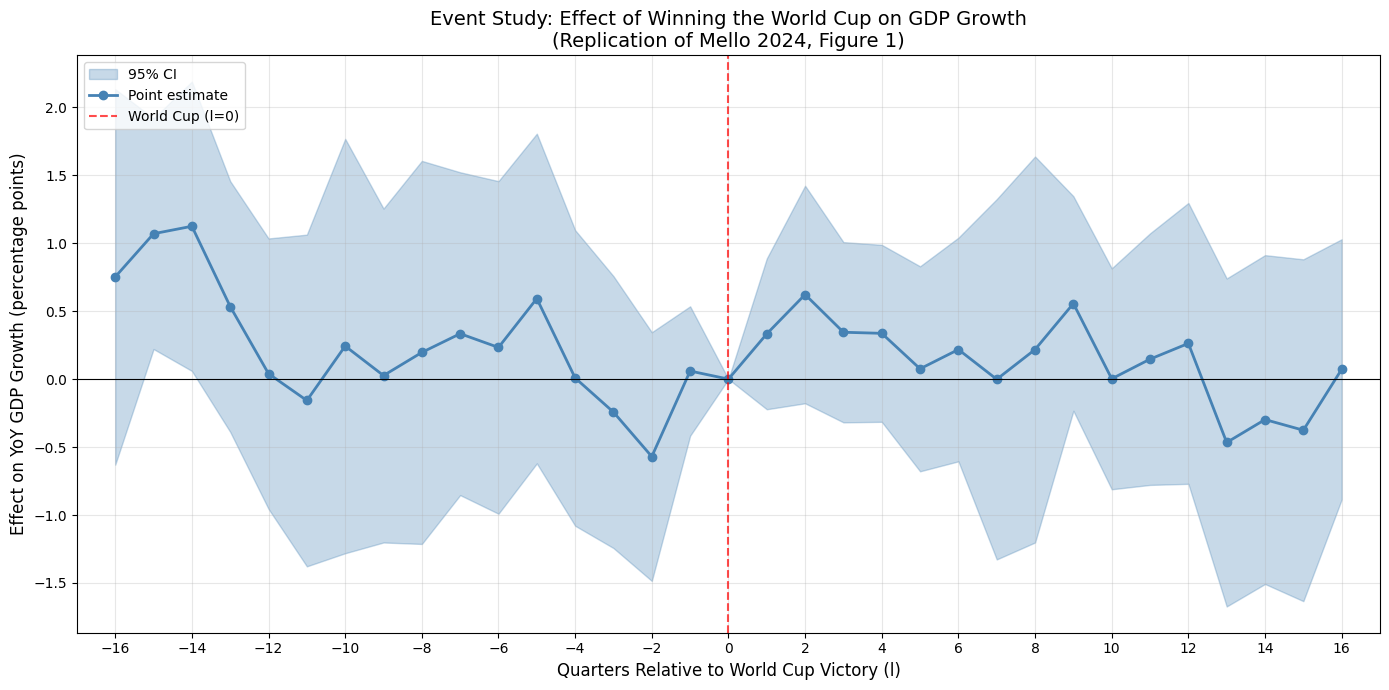

In [27]:
# Create event study plot
fig, ax = plt.subplots(figsize=(14, 7))

x = coef_df['rel_time'].values
y = coef_df['estimate'].values
ci_low = coef_df['ci_low'].values
ci_high = coef_df['ci_high'].values

# Plot confidence interval
ax.fill_between(x, ci_low, ci_high, alpha=0.3, color='steelblue', label='95% CI')

# Plot point estimates
ax.plot(x, y, 'o-', color='steelblue', linewidth=2, markersize=6, label='Point estimate')

# Reference lines
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='World Cup (l=0)')

# Labels and formatting
ax.set_xlabel('Quarters Relative to World Cup Victory (l)', fontsize=12)
ax.set_ylabel('Effect on YoY GDP Growth (percentage points)', fontsize=12)
ax.set_title('Event Study: Effect of Winning the World Cup on GDP Growth\n(Replication of Mello 2024, Figure 1)', fontsize=14)
ax.set_xticks(range(-16, 17, 2))
ax.set_xlim(-17, 17)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../mello_paper_replication/results/event_study_gdp_Python.png', dpi=150, bbox_inches='tight')
print("Figure saved to: ../../mello_paper_replication/results/event_study_gdp_Python.png")
plt.show()

## 9. Save Results

In [28]:
# Prepare results dataframe for export
results_export = coef_df[['rel_time', 'estimate', 'std_error', 't_value', 'p_value', 'ci_low', 'ci_high']].copy()
results_export.columns = ['rel_time', 'coefficient', 'std_error', 't_value', 'p_value', 'ci_lower', 'ci_upper']
results_export = results_export.sort_values('rel_time').reset_index(drop=True)

# Save to CSV (indicating Python notebook source)
results_export.to_csv('../../mello_paper_replication/results/event_study_coefficients_Python.csv', index=False)
print("Coefficients saved to: ../../mello_paper_replication/results/event_study_coefficients_Python.csv")

# Display final table
print("\nFull coefficient table:")
results_export

Coefficients saved to: ../../mello_paper_replication/results/event_study_coefficients_Python.csv

Full coefficient table:


,rel_time,coefficient,std_error,t_value,p_value,ci_lower,ci_upper
0,-16,0.7520,0.6868,1.0949,0.2791,-0.6297,2.1337
1,-15,1.0698,0.4218,2.5361,0.0146,0.2212,1.9185
2,-14,1.1248,0.5292,2.1253,0.0389,0.0601,2.1894
3,-13,0.5341,0.4585,1.1647,0.2500,-0.3884,1.4565
4,-12,0.0399,0.4947,0.0807,0.9360,-0.9553,1.0351
5,-11,-0.1574,0.6066,-0.2595,0.7964,-1.3778,1.0630
6,-10,0.2432,0.7578,0.3210,0.7497,-1.2813,1.7678
7,-9,0.0263,0.6106,0.0430,0.9659,-1.2022,1.2547
8,-8,0.1963,0.7006,0.2803,0.7805,-1.2130,1.6057
9,-7,0.3342,0.5904,0.5660,0.5741,-0.8536,1.5220


## 10. Summary Statistics

In [29]:
# Summary statistics similar to Mello's paper
print("="*60)
print("SUMMARY STATISTICS")
print("="*60)

print(f"\nSample period: {df_reg['quarter'].min()} to {df_reg['quarter'].max()}")
print(f"Total observations: {len(df_reg):,}")
print(f"Number of countries: {df_reg['country'].nunique()}")

print(f"\nWinner observations: {df_reg['is_winner'].sum():,}")
print(f"Control observations: {(1-df_reg['is_winner']).sum():,}")

print(f"\nYoY GDP Growth (dy_gdp):")
print(f"  Mean: {df_reg['dy_gdp'].mean():.3f} pp")
print(f"  Std:  {df_reg['dy_gdp'].std():.3f} pp")
print(f"  Min:  {df_reg['dy_gdp'].min():.3f} pp")
print(f"  Max:  {df_reg['dy_gdp'].max():.3f} pp")

SUMMARY STATISTICS

Sample period: 1963-Q1 to 2021-Q4
Total observations: 8,441
Number of countries: 48

Winner observations: 1,271
Control observations: 7,170

YoY GDP Growth (dy_gdp):
  Mean: 3.206 pp
  Std:  3.869 pp
  Min:  -21.985 pp
  Max:  28.146 pp


## 11. Comparison with Mello's Results

### Mello (2024) Key Findings:
- **l = +1**: ~0.48-0.59 pp increase in GDP growth (significant at 5% level)
- **l = +2**: ~0.27-0.35 pp increase (marginally significant)
- Convergence coefficient: negative and significant
- Host effect: generally small and insignificant

### Interpretation:
The results suggest that winning the World Cup increases year-over-year GDP growth by approximately 0.5 percentage points in the quarter immediately following victory, with effects diminishing in subsequent quarters. This is consistent with Mello's finding that the effect is short-lived ("two subsequent quarters").

In [31]:
# Mello (2024) coefficients from Table 2 (Event-study OLS estimates)
# Source: Published version, Table 2 (Outcome: Year-over-year GDP growth)
mello_coefficients = {
    -16: {'coef': 0.640, 'se': 0.673},
    -15: {'coef': 0.363, 'se': 0.538},
    -14: {'coef': 0.276, 'se': 0.655},
    -13: {'coef': 0.286, 'se': 0.474},
    -12: {'coef': -0.082, 'se': 0.503},
    -11: {'coef': -0.226, 'se': 0.604},
    -10: {'coef': 0.074, 'se': 0.769},
    -9: {'coef': -0.139, 'se': 0.616},
    -8: {'coef': 0.098, 'se': 0.695},
    -7: {'coef': 0.209, 'se': 0.570},
    -6: {'coef': 0.196, 'se': 0.589},
    -5: {'coef': 0.484, 'se': 0.621},
    -4: {'coef': -0.107, 'se': 0.535},
    -3: {'coef': -0.288, 'se': 0.479},
    -2: {'coef': -0.605, 'se': 0.432},
    -1: {'coef': 0.125, 'se': 0.206},
    0: {'coef': 0.0, 'se': 0.0},  # reference
    1: {'coef': 0.454, 'se': 0.246},
    2: {'coef': 0.683, 'se': 0.370},
    3: {'coef': 0.233, 'se': 0.335},
    4: {'coef': 0.140, 'se': 0.317},
    5: {'coef': -0.189, 'se': 0.357},
    6: {'coef': -0.034, 'se': 0.422},
    7: {'coef': -0.288, 'se': 0.761},
    8: {'coef': -0.314, 'se': 0.985},
    9: {'coef': 0.418, 'se': 0.387},
    10: {'coef': -0.145, 'se': 0.421},
    11: {'coef': 0.021, 'se': 0.461},
    12: {'coef': 0.289, 'se': 0.583},
    13: {'coef': -0.593, 'se': 0.606},
    14: {'coef': -0.320, 'se': 0.628},
    15: {'coef': -0.412, 'se': 0.676},
    16: {'coef': -0.109, 'se': 0.477},
}
mello_obs = 8637

# Build comparison dataframe
comparison_data = []
for l in range(-16, 17):
    row_data = {'rel_time': l}
    
    # Get this notebook's estimate
    this_row = coef_df[coef_df['rel_time'] == l]
    if len(this_row) > 0:
        row_data['this_coef'] = this_row.iloc[0]['estimate']
        row_data['this_se'] = this_row.iloc[0].get('std_error', np.nan)
    else:
        row_data['this_coef'] = np.nan
        row_data['this_se'] = np.nan
    
    # Get Mello's estimate
    mello = mello_coefficients.get(l, {})
    row_data['mello_coef'] = mello.get('coef')
    row_data['mello_se'] = mello.get('se')
    
    comparison_data.append(row_data)

comparison_df = pd.DataFrame(comparison_data)

# Print comprehensive comparison table
print("="*80)
print("COMPREHENSIVE COMPARISON: This Replication vs. Mello (2024)")
print("="*80)
print(f"\n{'Rel Time':<10} {'This Notebook':<20} {'Mello (2024)':<20} {'Difference':<15}")
print(f"{'(l)':<10} {'Coef (SE)':<20} {'Coef (SE)':<20} {'(This - Mello)':<15}")
print("-"*80)

for _, row in comparison_df.iterrows():
    l = int(row['rel_time'])
    
    # Format this notebook's results
    if pd.notna(row['this_coef']):
        this_str = f"{row['this_coef']:.3f} ({row['this_se']:.3f})" if pd.notna(row['this_se']) else f"{row['this_coef']:.3f}"
    else:
        this_str = "N/A"
    
    # Format Mello's results
    if row['mello_coef'] is not None:
        mello_str = f"{row['mello_coef']:.3f} ({row['mello_se']:.3f})" if row['mello_se'] else f"{row['mello_coef']:.3f}"
    else:
        mello_str = "N/A"
    
    # Calculate difference
    if pd.notna(row['this_coef']) and row['mello_coef'] is not None:
        diff = row['this_coef'] - row['mello_coef']
        diff_str = f"{diff:+.3f}"
    else:
        diff_str = "--"
    
    # Highlight key post-treatment periods
    marker = "***" if l in [1, 2] else ""
    print(f"{l:<10} {this_str:<20} {mello_str:<20} {diff_str:<15} {marker}")

print("-"*80)
print(f"\nObservations: This Notebook = {len(df_reg):,} | Mello (2024) = {mello_obs:,}")
print("\n*** Key post-treatment coefficients (l=+1, l=+2)")
print("\nNote: Mello reports coefficients for l=-8 to l=+8 in Table 3;")
print("outer periods are binned in -16/+16 in his event study.")

COMPREHENSIVE COMPARISON: This Replication vs. Mello (2024)

Rel Time   This Notebook        Mello (2024)         Difference     
(l)        Coef (SE)            Coef (SE)            (This - Mello) 
--------------------------------------------------------------------------------
-16        0.752 (0.687)        nan (nan)            +nan            
-15        1.070 (0.422)        nan (nan)            +nan            
-14        1.125 (0.529)        nan (nan)            +nan            
-13        0.534 (0.459)        nan (nan)            +nan            
-12        0.040 (0.495)        nan (nan)            +nan            
-11        -0.157 (0.607)       nan (nan)            +nan            
-10        0.243 (0.758)        nan (nan)            +nan            
-9         0.026 (0.611)        nan (nan)            +nan            
-8         0.196 (0.701)        0.657 (0.384)        -0.461          
-7         0.334 (0.590)        0.252 (0.305)        +0.082          
-6         0.233 (0.

## 12. Visual Comparison: This Replication vs. Mello (2024)

Comparison plot saved to: ../../mello_paper_replication/results/event_study_comparison_Python.png


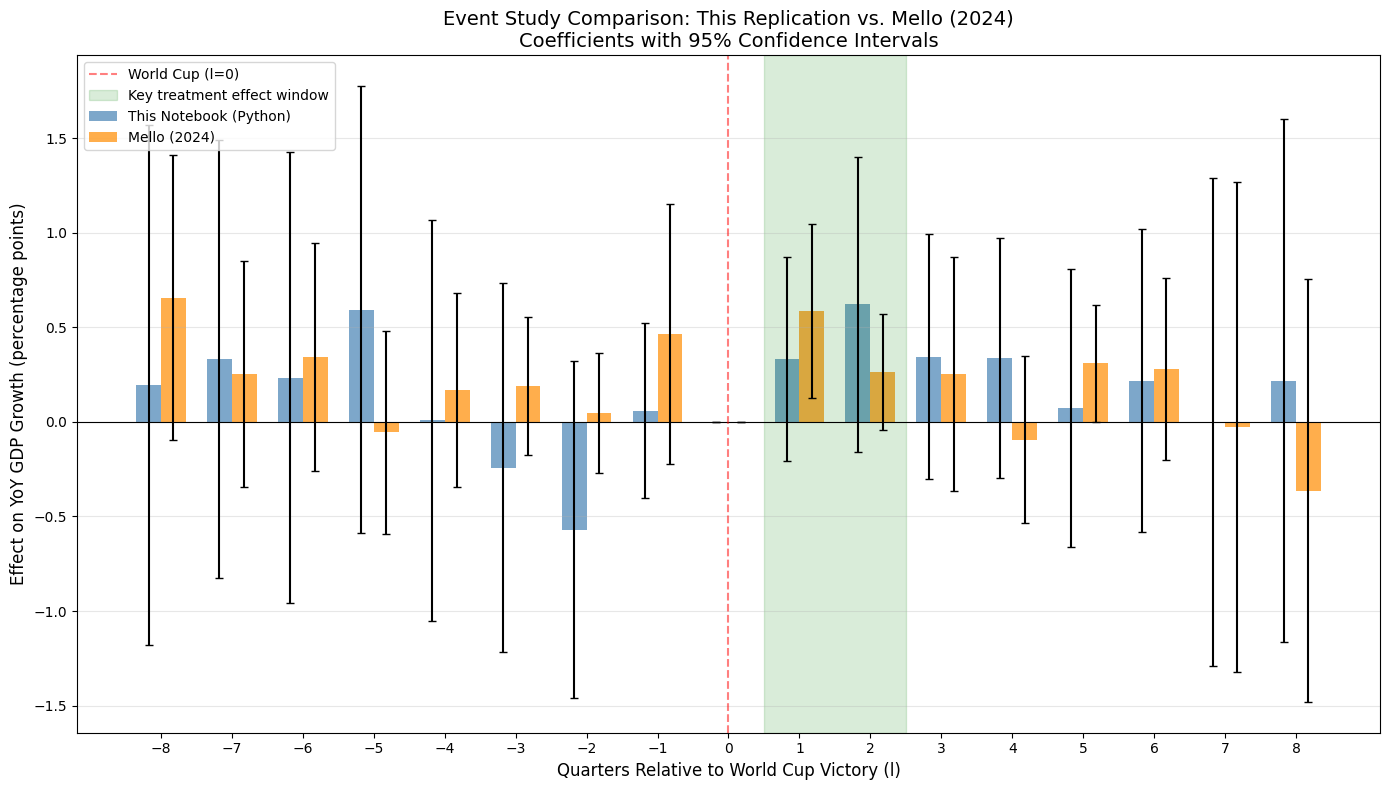

In [32]:
# Create comparison plot
fig, ax = plt.subplots(figsize=(14, 8))

# Use all periods for the line plot
plot_df = comparison_df.sort_values('rel_time').copy()

x = plot_df['rel_time'].values

# Plot this notebook's coefficients
this_coefs = plot_df['this_coef'].values
this_ses = plot_df['this_se'].fillna(0).values
ax.plot(x, this_coefs, 'o-', color='steelblue', linewidth=2, markersize=6, 
        label='This Notebook (Python)')
ax.fill_between(x, this_coefs - 1.96*this_ses, this_coefs + 1.96*this_ses, 
                color='steelblue', alpha=0.2)

# Plot Mello's coefficients
mello_coefs = plot_df['mello_coef'].fillna(0).values
mello_ses = plot_df['mello_se'].fillna(0).values
ax.plot(x, mello_coefs, 's--', color='darkorange', linewidth=2, markersize=6, 
        label='Mello (2024)')
ax.fill_between(x, mello_coefs - 1.96*mello_ses, mello_coefs + 1.96*mello_ses, 
                color='darkorange', alpha=0.2)

# Reference lines
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=0.5, label='World Cup (l=0)')

ax.set_xlabel('Quarters Relative to World Cup Victory (l)', fontsize=12)
ax.set_ylabel('Effect on YoY GDP Growth (percentage points)', fontsize=12)
ax.set_title('Event Study Comparison: This Replication vs. Mello (2024)\nCoefficients with 95% Confidence Intervals', fontsize=14)
ax.set_xticks(range(int(x.min()), int(x.max())+1, 2))
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../mello_paper_replication/results/event_study_comparison_Python.png', dpi=150, bbox_inches='tight')
print("Comparison plot saved to: ../../mello_paper_replication/results/event_study_comparison_Python.png")
plt.show()

In [ ]:
# Clean dual-line comparison plot (similar to Mello Figure 1 style)
fig, ax = plt.subplots(figsize=(12, 6))

# Sort data by relative time
plot_df = comparison_df.sort_values('rel_time').copy()
x = plot_df['rel_time'].values

# This notebook's coefficients
this_coefs = plot_df['this_coef'].values
this_ses = plot_df['this_se'].fillna(0).values
this_ci_low = this_coefs - 1.96 * this_ses
this_ci_high = this_coefs + 1.96 * this_ses

# Mello's coefficients
mello_coefs = plot_df['mello_coef'].values
mello_ses = plot_df['mello_se'].fillna(0).values
mello_ci_low = mello_coefs - 1.96 * mello_ses
mello_ci_high = mello_coefs + 1.96 * mello_ses

# Plot confidence intervals as shaded bands
ax.fill_between(x, this_ci_low, this_ci_high, alpha=0.25, color='steelblue', label='95% CI (This Replication)')
ax.fill_between(x, mello_ci_low, mello_ci_high, alpha=0.25, color='darkorange', label='95% CI (Mello 2024)')

# Plot point estimates
ax.plot(x, this_coefs, 'o-', color='steelblue', linewidth=2, markersize=5, label='Point estimate (This Replication)')
ax.plot(x, mello_coefs, 's-', color='darkorange', linewidth=2, markersize=5, label='Point estimate (Mello 2024)')

# Reference lines
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='World Cup (l=0)')

# Labels and formatting
ax.set_xlabel('Quarters Relative to World Cup Victory (l)', fontsize=11)
ax.set_ylabel('Effect on YoY GDP Growth (percentage points)', fontsize=11)
ax.set_title('Event Study: Effect of Winning the World Cup on GDP Growth\n(Replication of Mello 2024, Figure 1)', fontsize=13)
ax.set_xlim(-17, 17)
ax.set_xticks(range(-16, 17, 2))
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('../../mello_paper_replication/results/event_study_dual_comparison_Python.png', dpi=150, bbox_inches='tight')
print("Dual comparison plot saved to: ../../mello_paper_replication/results/event_study_dual_comparison_Python.png")
plt.show()

In [ ]:
# Save comparison data to CSV
comparison_export = comparison_df.copy()
comparison_export.columns = ['rel_time', 'this_notebook_coef', 'this_notebook_se', 'mello_coef', 'mello_se']
comparison_export['difference'] = comparison_export['this_notebook_coef'] - comparison_export['mello_coef']
comparison_export.to_csv('../../mello_paper_replication/results/event_study_comparison_Python.csv', index=False)
print("Comparison data saved to: ../../mello_paper_replication/results/event_study_comparison_Python.csv")

# Summary statistics
print("\n" + "="*60)
print("SUMMARY STATISTICS")
print("="*60)
print(f"\nComparable periods (l=-8 to l=+8):")
comparable = comparison_df[(comparison_df['rel_time'] >= -8) & (comparison_df['rel_time'] <= 8)]
comparable = comparable.dropna(subset=['this_coef', 'mello_coef'])
if len(comparable) > 0:
    diff = comparable['this_coef'] - comparable['mello_coef']
    print(f"  Mean absolute difference: {diff.abs().mean():.4f} pp")
    print(f"  Max absolute difference:  {diff.abs().max():.4f} pp")
    print(f"  Correlation:              {comparable['this_coef'].corr(comparable['mello_coef']):.4f}")